In [2]:
# import libraries
import yfinance as yf
import datetime
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# define variables
SYMBOL = "^GSPC"
PCT_THRESH = 20

In [4]:
# define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2024, 1, 1)
YEARS = (END - START).days / 365.25

In [5]:
# download data
price = yf.download(SYMBOL, start=START, end=END)

price.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,4754.629883,3046770000
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,4774.750000,2513910000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,4783.350098,2698860000
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,4769.830078,3126060000


In [6]:
# drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078


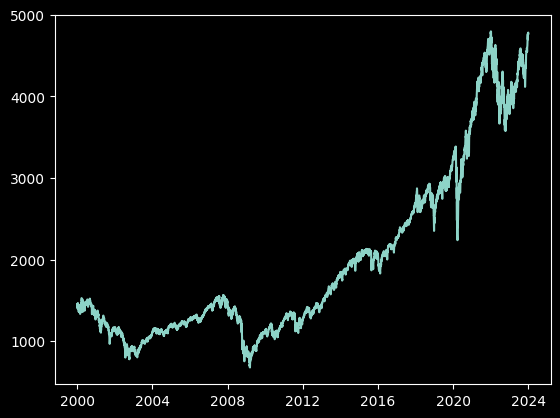

In [8]:
plt.style.use('dark_background')
plt.plot(price.Close)

plt.show()

In [9]:
# calculate benchmark return
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1

# calculate daily range
price['Range'] = price.High - price.Low

# calculate distance from close to low
price['Dist'] = abs(price.Close - price.Low)

# distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct
Date,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,36.169922,17.859863,49.377666
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,26.270020,16.299805,62.047174
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,16.490234,12.680176,76.895061
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,12.319824,2.370117,19.238239
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,36.439941,17.839844,48.956840


In [10]:
# entry triggers
price['Long'] = price.Pct < PCT_THRESH

# system return
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct,Long,Sys_Ret
Date,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,36.169922,17.859863,49.377666,False,1.000000
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,26.270020,16.299805,62.047174,False,1.000000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,16.490234,12.680176,76.895061,False,1.000000
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,12.319824,2.370117,19.238239,True,1.000000
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,36.439941,17.839844,48.956840,False,0.997174


In [12]:
# benchmark up and down days
bench_win = price.Return[price.Return > 1.0].count()
bench_loss = price.Return[price.Return < 1.0].count()
bench_winrate = round((bench_win / (bench_win + bench_loss)) * 100, 2)

# extract the up and down days
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Winrate: {bench_winrate}%')
print('')
print(f'Trade Won: {sys_win}')
print(f'Trade Loss: {sys_loss}')
print(f'System Winrate: {sys_winrate}%')

Benchmark Winrate: 53.47%

Trade Won: 751
Trade Loss: 535
System Winrate: 58.4%


In [13]:
def simulate(price, threshold):

    # entry triggers
    price['Long'] = price.Pct < threshold

    # system return
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)

    # extract the up and down days
    sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
    sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
    sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

    return sys_winrate

In [15]:
# blank list for brackest results
results = []
pct_range = range(5, 101)

for pct in pct_range:
    results.append(simulate(price, pct))

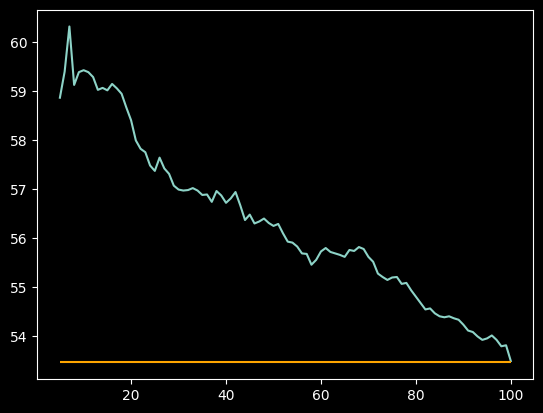

In [16]:
plt.plot(pct_range, results)
plt.hlines(bench_winrate, pct_range[0], pct_range[-1], colors = 'orange')

plt.show()

In [17]:
print(f'Max Systems Winrate: {max(results)}, at {pct_range[results.index((max(results)))]}')
print(f'Benchmark Winrate: {bench_winrate}')

Max Systems Winrate: 60.31, at 7
Benchmark Winrate: 53.47
